In [1]:
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# 1. Cargar datos
df = pd.read_csv("caso3_rrhh_renuncias.csv")

In [3]:
df.head()

,antiguedad_meses,satisfaccion,departamento,promociones,tipo_contrato,home_office,renuncia
0,29,1.5,Ventas,0,Indefinido,1,0
1,24,3.1,Recursos Humanos,1,Indefinido,1,0
2,113,1.7,Ventas,0,Indefinido,1,1
3,59,3.9,Recursos Humanos,0,Indefinido,1,0
4,6,2.5,Finanzas,1,Temporal,0,0


In [4]:
# 2. Crear variable derivada para análisis: empleados satisfechos que igual se van
df['satisfecho_y_se_va'] = ((df['satisfaccion'] >= 4.0) & (df['renuncia'] == 1)).astype(int)

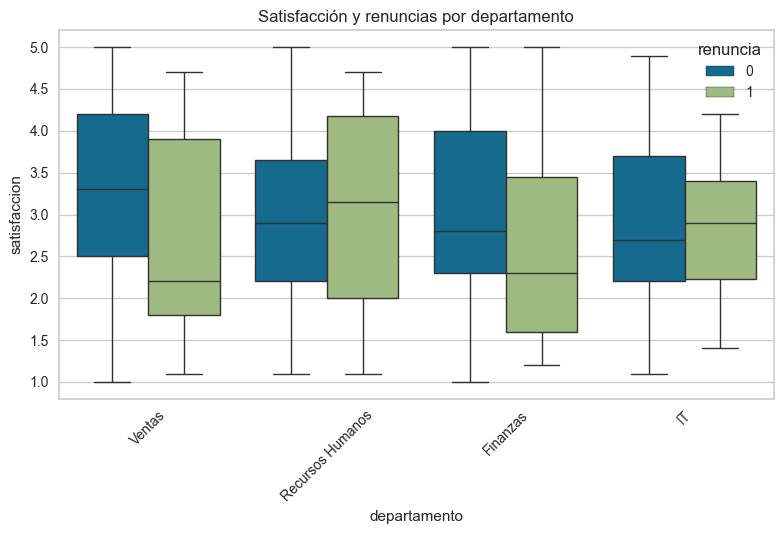

In [5]:
# 3. Visualizar si existen patrones ocultos
sns.boxplot(data=df, x='departamento', y='satisfaccion', hue='renuncia')
plt.title("Satisfacción y renuncias por departamento")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# 4. Configuración PyCaret
clf = setup(data=df,
            target='renuncia',
            session_id=2025,
            categorical_features=['departamento', 'tipo_contrato'],
            ignore_features=['satisfecho_y_se_va'],
            remove_multicollinearity=True,
            multicollinearity_threshold=0.85,
            polynomial_features=True,
            bin_numeric_features=['antiguedad_meses', 'satisfaccion']
            )

,Description,Value
0,Session id,2025
1,Target,renuncia
2,Target type,Binary
3,Original data shape,"(280, 8)"
4,Transformed data shape,"(280, 39)"
5,Transformed train set shape,"(196, 39)"
6,Transformed test set shape,"(84, 39)"
7,Ignore features,1
8,Numeric features,4
9,Categorical features,2


In [11]:
# 5. Seleccionar el mejor modelo con énfasis en evitar falsos negativos (Recall)
best = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7663,0.6609,0.5167,0.2292,0.3126,0.1958,0.2238,0.1630
lda,Linear Discriminant Analysis,0.8674,0.6106,0.2500,0.2500,0.2367,0.1825,0.1887,0.0070
svm,SVM - Linear Kernel,0.7792,0.5984,0.1500,0.1125,0.0889,0.0170,0.0286,0.0060
dt,Decision Tree Classifier,0.7555,0.4835,0.1333,0.0700,0.0917,-0.0383,-0.0387,0.1300
ridge,Ridge Classifier,0.8829,0.6247,0.1000,0.1500,0.1167,0.0948,0.0989,0.0060
rf,Random Forest Classifier,0.8679,0.5293,0.1000,0.1500,0.1167,0.0740,0.0773,0.0190
ada,Ada Boost Classifier,0.8229,0.6136,0.1000,0.0833,0.0900,0.0163,0.0122,0.0090
gbc,Gradient Boosting Classifier,0.8021,0.5925,0.1000,0.0833,0.0900,-0.0136,-0.0145,0.0110
et,Extra Trees Classifier,0.8324,0.4962,0.1000,0.1500,0.1167,0.0373,0.0400,0.0170
lr,Logistic Regression,0.8574,0.6392,0.0500,0.1000,0.0667,0.0181,0.0214,0.2080


In [12]:
# 6. Ajustar modelo y obtener curva de SHAP
final_model = tune_model(best, optimize='Recall')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8500,0.9722,1.0000,0.4000,0.5714,0.5000,0.5774
1,0.8500,0.7222,0.5000,0.3333,0.4000,0.3182,0.3267
2,0.7500,0.8889,0.5000,0.2000,0.2857,0.1667,0.1925
3,0.6000,0.5556,0.5000,0.1250,0.2000,0.0476,0.0680
4,0.6500,0.5784,0.6667,0.2500,0.3636,0.1860,0.2287
5,0.7000,0.3333,0.0000,0.0000,0.0000,-0.1765,-0.1765
6,0.8421,0.8529,1.0000,0.4000,0.5714,0.4956,0.5739
7,0.7895,0.8529,0.5000,0.2500,0.3333,0.2245,0.2435
8,0.8421,0.5294,0.5000,0.3333,0.4000,0.3133,0.3218


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [14]:
# 7. Crear matriz de decisiones para equipo de talento
preds = predict_model(final_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6310,0.6338,0.4000,0.1379,0.2051,0.0341,0.0423


In [16]:
print(preds.columns)

Index(['antiguedad_meses', 'satisfaccion', 'departamento', 'promociones',
       'tipo_contrato', 'home_office', 'renuncia', 'prediction_label',
       'prediction_score'],
      dtype='object')


In [17]:
df_resultados = pd.concat([df.reset_index(drop=True), preds[['prediction_label', 'prediction_score']]], axis=1)

In [18]:
# 8. Filtrar empleados en riesgo con Score > 0.6 y Label = 1
foco_retencion = df_resultados[(df_resultados['prediction_label'] == 1) & (df_resultados['prediction_score'] > 0.6)]

In [19]:
# 9. Simular el impacto de una política de flexibilidad laboral
sim = df.copy()
sim.loc[(sim['tipo_contrato'] == 'Temporal') & (sim['home_office'] == 0), 'home_office'] = 1
sim_preds = predict_model(final_model, data=sim)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7393,0.7348,0.5312,0.2267,0.3178,0.1876,0.2137


In [20]:
# 10. Comparar porcentaje de renuncias esperadas antes y después
antes = preds['prediction_label'].mean()
despues = sim_preds['prediction_label'].mean()
impacto = (antes - despues) * 100
print(f"Política simulada de trabajo remoto reduciría renuncias estimadas en: {impacto:.2f}%")

Política simulada de trabajo remoto reduciría renuncias estimadas en: 7.74%


In [21]:
# 11. Guardar modelo final
save_model(final_model, 'modelo_retencion_talento')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['antiguedad_meses', 'satisfaccion',
                                              'promociones', 'home_office'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(ex...
                                     transformer=RemoveMulticollinearity(threshold=0.85))),
                 ('bin_numeric_features',